# Silcton MRI Processing and Analyses

Data, info on Virtual Silcton, analysis plan can all be found here: https://osf.io/ea99d/

In [38]:
#import packages

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import pandas as pd
import scipy
from cycler import cycler
import seaborn as sns
# For statistics. Requires statsmodels 5.0 or more
from statsmodels.formula.api import ols



In [2]:
def zscore(column, data):
    #Calculate and return the z-score value of a variable from a DataFrame
    zscoredVariable = (data[column] - data[column].mean())/data[column].std(ddof=0)
    return zscoredVariable

In [3]:
def doAnova(dependentVar,data):
    data = data[np.isfinite(data[dependentVar])]
    grps = pd.unique(data.groups.values)
    d_data = {grp:data[dependentVar][data.groups == grp] for grp in grps}
    F, p = scipy.stats.f_oneway(d_data[1], d_data[2], d_data[3])
    print('F = ',F,'p = ',p)

In [4]:
def stderror(dependentVar):
    std = np.std(dependentVar)
    n = len(dependentVar)
    sem = std / np.sqrt(n)
    
    return sem

In [5]:
def pearsonRtoT(xname,yname,data):
    """Transform a Pearson R into a t-value for Bayes calculator"""
    x = data.loc[:,xname]
    y = data.loc[:,yname]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    n = len(data[xname])
    t = np.sqrt((n-2)*(r_value**2)/(1-r_value**2))
    
    print('The correlation is r({}) = {:.2f}, p = {:.2f}. T-value = {:.2f}'.format(n,r_value, p_value,t))



In [6]:
def saveTheFig(name1,name2,f):
    
    figName = 'scatter'+name1.capitalize()+name2.capitalize()+'.pdf'
    
    prompt = 'save figure with ' + name1.capitalize() + name2.capitalize() + '? y/n '
    
    a = input(prompt)

    if a.lower() == 'y':
        f.savefig(figName, format='pdf',transparent=True,)


In [7]:
def formatPlot(x,y,plot,linecolor,ax1):
    ax1.set_xlabel(x.name,fontsize=20)
    ax1.set_ylabel(y.name,fontsize=20)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    fit = np.polyfit(x, y, deg=1) # calculate regression line
    ax1.plot(x, fit[0] * x + fit[1], color=linecolor,label='',linewidth=2) # print lines as black
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    pearsonR = 'r = ' + "{0:.2f}".format(r_value)
    locationOffset = (min(y) - max(y)) / 10
    location = (max(x)*fit[0] + fit[1]) + locationOffset
    ax1.text(max(x),location,pearsonR,horizontalalignment='right',fontsize=14,color=linecolor)
    ax1.legend(edgecolor='black',fontsize=14)
    fig = plt.gcf()
    fig.set_size_inches(10.5, 10.5)



In [8]:
def makeNavGroupPlot(xname,yname,data,savefig=False):

    """Will make a formatted scatter plot colored by all three groups"""
    
    x = data.loc[:,xname]
    y = data.loc[:,yname]
    f, ax1 = plt.subplots(1)
    group_dict = {1:['#00B050','Integrators'],2:['#E46C0A','Non-Integrators'],3:['#4BACC6','Imprecise Navigators']}



    for kind in group_dict:
        d = data[data.int1non2imp3==kind]
        plt.scatter(d.loc[:,xname], d.loc[:,yname],
            c = group_dict[kind][0],label=group_dict[kind][1],s=60)
        plt.hlines(np.mean(d.loc[:,yname]), np.mean(d.loc[:,xname]) - stderror(d.loc[:,xname]), np.mean(d.loc[:,xname]) + stderror(d.loc[:,xname]), linestyle='dashed')
        plt.vlines(np.mean(d.loc[:,xname]), np.mean(d.loc[:,yname]) - stderror(d.loc[:,yname]), np.mean(d.loc[:,yname]) + stderror(d.loc[:,yname]), linestyle='dashed')
        plt.plot(np.mean(d.loc[:,xname]), np.mean(d.loc[:,yname]), marker='o', markersize=20
                 , color=group_dict[kind][0], markeredgecolor='black')
        formatPlot(d.loc[:,xname],d.loc[:,yname],f,group_dict[kind][0],ax1)

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    pearsonR = 'r = ' + "{0:.2f}".format(r_value)
    
    fit = np.polyfit(x, y, deg=1) # calculate regression line
    ax1.plot(x, fit[0] * x + fit[1], color='gray',label='Total',linewidth=2) # print lines as black

    locationOffset = (max(y) - min(y)) / 20
    location = (max(x)*fit[0] + fit[1]) + locationOffset
    ax1.text(max(x),location,pearsonR,horizontalalignment='right', fontsize=14)

    if savefig:
        saveTheFig(x.name,y.name,f)



## Import and process data

In [9]:
#import and process data - including Z-scoring all columns

data = pd.read_csv('https://raw.githubusercontent.com/smweis/Silcton_MRI/master/public_data/DataAnalysisWith90Participants_Jupyter.csv')
rawData = data[:]



#Normalize all float variables

for i in data:
    if i in ['Batch','ID','Education','int1non2imp3']:
        continue
    elif data[i].dtype != object:
        data[i] = zscore(i,data)
    else:    
        continue
        



#reverse the pointing ones to be higher = good score
data['pointBetween'] = -1*(data['pointBetween'])
data['pointWithin'] = -1*(data['pointWithin'])
data['pointTotal'] = -1*(data['pointTotal'])



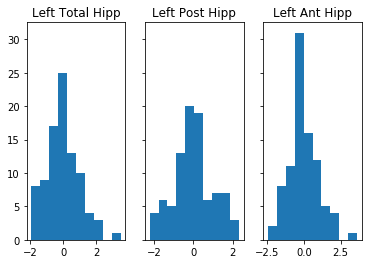

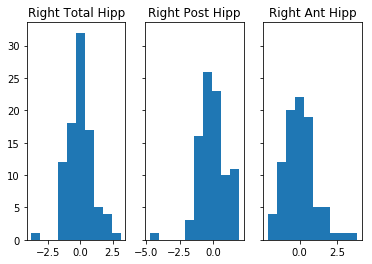

In [10]:

#check any histograms
fig, axes = plt.subplots(1, 3,sharey=True)
axes[0].hist(data['ashs_ltotalhipp'])
axes[0].set_title('Left Total Hipp')
axes[1] .hist(data['ashs_post_lhc'])
axes[1].set_title('Left Post Hipp')
axes[2] .hist(data['ashs_ant_lhc'])
axes[2].set_title('Left Ant Hipp')
fig, axes = plt.subplots(1, 3, sharey=True)
axes[0].hist(data['ashs_rtotalhipp'])
axes[0].set_title('Right Total Hipp')
axes[1] .hist(data['ashs_post_rhc'])
axes[1].set_title('Right Post Hipp')
axes[2] .hist(data['ashs_ant_rhc'])
axes[2].set_title('Right Ant Hipp')
plt.show()

In [11]:
display(data['gender'].value_counts())
display(data.race.value_counts())
display("Participant's average age was {:.1f} years (SD = {:.2f})".format(rawData.age.mean(),rawData.age.std()))

Female    54
Male      36
Name: gender, dtype: int64

White                 39
Asian                 18
Black                 15
Hispanic               7
Hispanic / White       3
Black / Hispanic       2
Asian / White          1
Asian / Black          1
Other                  1
Do not wish to say     1
Hispanic / Asian       1
Black / White          1
Name: race, dtype: int64

"Participant's average age was 23.1 years (SD = 3.94)"

In [22]:
#exclude outliers from total hippocampal volume (both high and low outliers)
dataWithoutOutliers = data[:]
dataWithoutOutliers = dataWithoutOutliers[dataWithoutOutliers['ashs_rtotalhipp'] < 3.8]
dataWithoutOutliers = dataWithoutOutliers[dataWithoutOutliers['ashs_rtotalhipp'] > -3.8]

dataWithoutOutliers.shape

(89, 63)

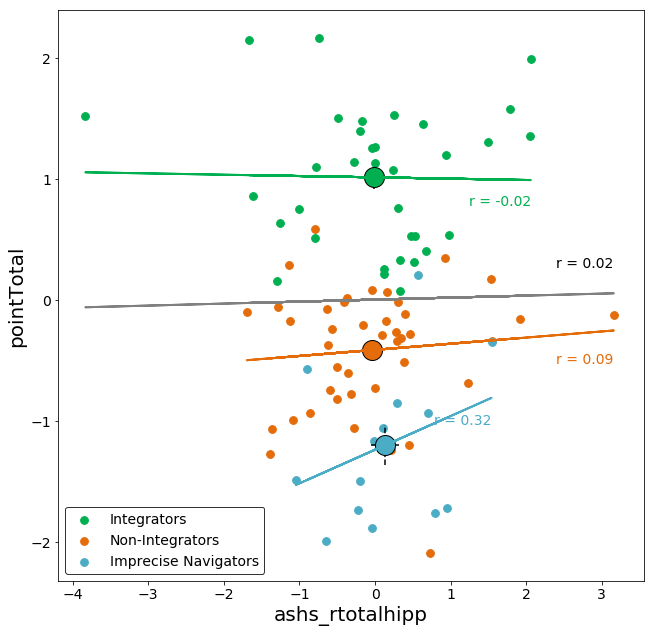

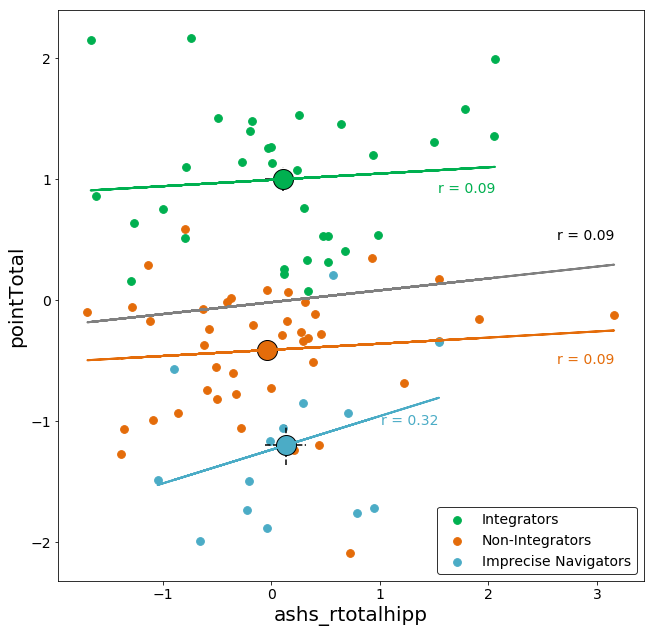

In [24]:
makeNavGroupPlot('ashs_rtotalhipp','pointTotal',data)
makeNavGroupPlot('ashs_rtotalhipp','pointTotal',dataWithoutOutliers)

In [25]:
pearsonRtoT('ashs_rtotalhipp','pointTotal',data=data)
pearsonRtoT('ashs_rtotalhipp','pointTotal',data=dataWithoutOutliers)
pearsonRtoT('rhc','pointTotal',data=data)

The correlation is r(90) = 0.02, p = 0.88. T-value = 0.15
The correlation is r(89) = 0.09, p = 0.40. T-value = 0.85
The correlation is r(90) = 0.07, p = 0.52. T-value = 0.64


## Create scatterplots

In [41]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

C:\Users\stweis\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:106: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


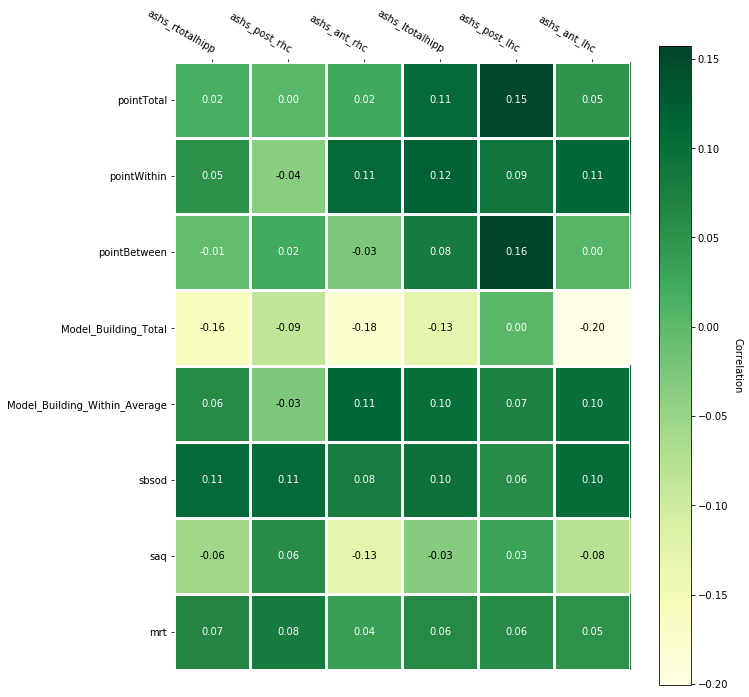

In [65]:
#https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html

behavioral_measures = ['pointTotal','pointWithin','pointBetween','Model_Building_Total','Model_Building_Within_Average','sbsod','saq','mrt']

hipp_measures = ['ashs_rtotalhipp','ashs_post_rhc','ashs_ant_rhc','ashs_ltotalhipp','ashs_post_lhc','ashs_ant_lhc']

other_brain_measures = ['rcaud','lcaud','ramyg','lamyg','cortexVol','brainVol','csf']


heatMap2 = pd.DataFrame(np.empty([len(behavioral_measures),len(hipp_measures)]))

for i,j in enumerate(behavioral_measures):
    for k,l in enumerate(hipp_measures):
        corrVal = np.corrcoef(data[j],data[l])
        heatMap2.iloc[i,k] = corrVal[0,1]



fig, ax = plt.subplots(figsize=[10,10])

im, cbar = heatmap(heatMap2, behavioral_measures, hipp_measures, ax=ax,
                   cmap="YlGn", cbarlabel="Correlation")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()

In [66]:
a = np.corrcoef(data['Model_Building_Total'],data['pointTotal'])
print(a[0,1])

0.5776297292939884


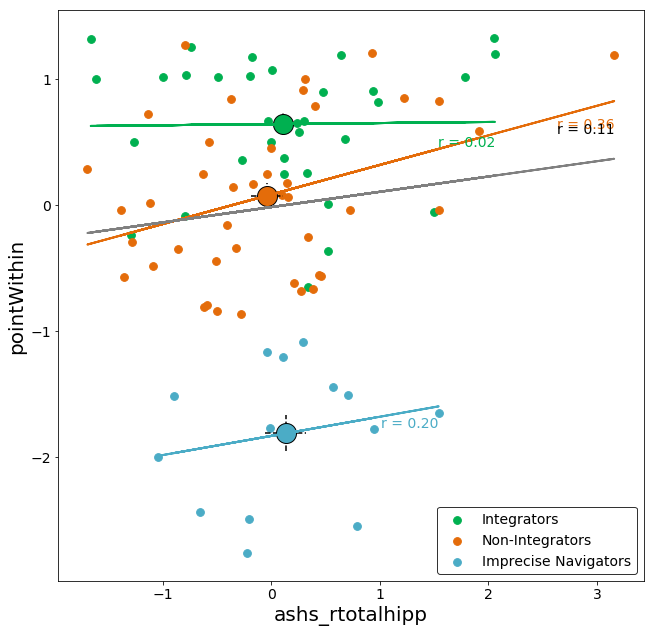

In [29]:
# Figures for iNav Poster

makeNavGroupPlot('ashs_rtotalhipp','pointWithin',dataWithoutOutliers)


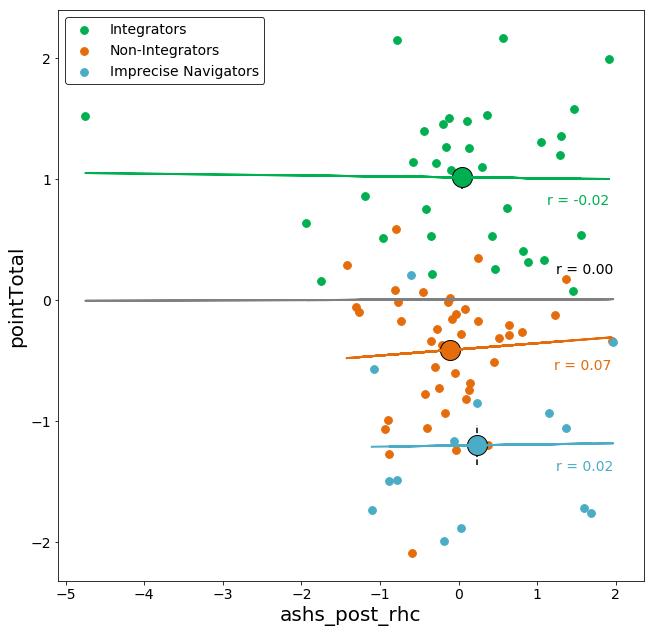

In [16]:
makeNavGroupPlot('ashs_post_rhc','pointTotal',data)


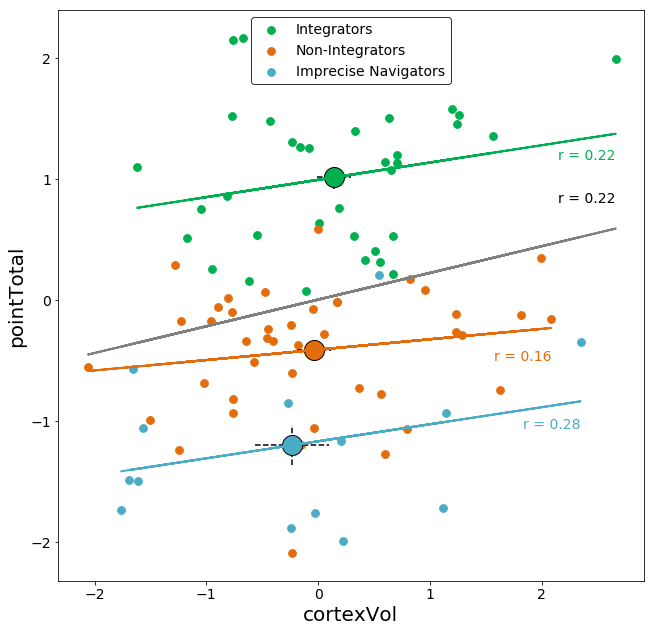

In [17]:
makeNavGroupPlot('cortexVol','pointTotal',data)


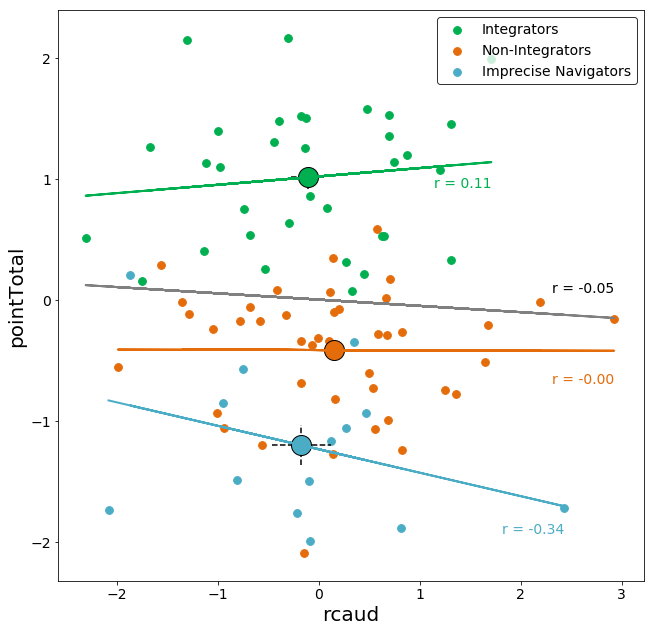

In [18]:
makeNavGroupPlot('rcaud','pointTotal',data)


In [19]:
makeNavGroupPlot('ashs_rhc','sbsod',data)


KeyError: 'the label [ashs_rhc] is not in the [columns]'

In [ ]:
makeNavGroupPlot('ashs_rhc','mrt',data)


In [ ]:
makeNavGroupPlot('ashs_ant_rhc','pointTotal',data)

In [ ]:
# ANOVAS on three groups (not on poster)

doAnova('ashs_post_rhc',data)



In [ ]:
# additional analyses for control (numbers not on poster)

nonannormedData = data.dropna()


model_fit = ols("pointTotal ~ lhc_bodytail * gender * age * cortexVol", data).fit()
print(model_fit.summary())



In [ ]:
# fitted values (need a constant term for intercept)
model_fitted_y = model_fit.fittedvalues
# model residuals
model_residuals = model_fit.resid
# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]


plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'pointTotal', data=data, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')


plt.show()



In [ ]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    fig = plt.figure(figsize=(size,size))
    ax1 = fig.add_subplot(111)
    cmap = plt.cm.get_cmap('jet')
    a = df.corr()
    np.fill_diagonal(a.values,np.nan)
    masked_array = np.ma.array (a, mask=np.isnan(a))
    cmap.set_bad('black',1.)
    ax1.imshow(masked_array, interpolation='nearest', cmap=cmap)
    cax = ax1.imshow(a, interpolation="nearest", cmap=cmap)
    plt.xticks(range(len(df.columns)), df.columns);
    plt.yticks(range(len(df.columns)), df.columns);
    print(a)
    fig.colorbar(cax)
    return a

order = [0,19,21,10,11,9,12,13,14,]
cols = noOutliers.columns.tolist()

mylist = [ cols[i] for i in order]

orderedNormedData = noOutliers[mylist]
corrMat = plot_corr(orderedNormedData,20)
plt.show()

#a = noOutliers.corr()
#display(a.style.background_gradient())
nonanOrderedData = orderedNormedData.dropna()
g = sns.clustermap(nonanOrderedData)

"""Index(['brainVol', 'cortexVol', 'lhc', 'rhc', 'lamyg', 'ramyg', 'csf',
       'pointBetween', 'pointWithin', 'pointTotal', 'rcaud', 'lcaud', 'sbsod',
       'wrat', 'mrt', 'groups', 'age', 'batch', 'gender', 'ashs_rhc',
       'ashs_lhc', 'ashs_post_rhc', 'ashs_post_lhc', 'ashs_ant_rhc',
       'ashs_ant_lhc', 'ashs_total_hipp', 'ashs_rerc', 'ashs_lerc',
       'ashs_lphc', 'ashs_rphc', 'ashs_lbr35', 'ashs_rbr35', 'ashs_lbr36',
       'ashs_rbr36'],"""

In [ ]:
pwd